In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [3]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
disallowmissing!(count_data)

,messages
,Float64
1,13.0
2,24.0
3,8.0
4,24.0
5,7.0
6,35.0
7,14.0
8,11.0
9,15.0


In [4]:
N = length(count_data.messages)

74

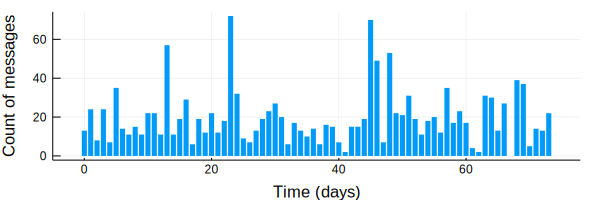

In [5]:
bar(0:N-1, count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
とする.
### まずは一番な単純なモデル
\begin{align}
\lambda \sim \text{Exp}(\alpha)
\end{align}
のモデルを作ってみる。$\alpha$は計数データの平均の逆数とする。Distribution.jlにおけるパラメーターの取り方は、PyMCと異なることに留意。  
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Continuous-Distributions-1

In [6]:
theta = mean(count_data.messages)

19.743243243243242

In [7]:
model0 = Model(
    
    obs = Stochastic(1,
        (ls, N) ->
            UnivariateDistribution[Poisson(ls[i]) for i in 1:N],
        false
    ),
    
    ls = Logical(1, (lambda, N) -> fill(lambda, N), false),
    
    lambda = Stochastic(theta -> Exponential(theta)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
ls:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]


In [8]:
data0 = Dict{Symbol, Any}(
    :obs => count_data.messages,
    :theta => theta,
    :N => length(count_data.messages),
)

Dict{Symbol,Any} with 3 entries:
  :N     => 74
  :obs   => [13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0,…
  :theta => 19.7432

In [9]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => theta,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])

In [10]:
scheme0 = [AMWG([:lambda], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [11]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [5:20:18 of 5:20:23 remaining]
      From worker 3:	Chain 3:   0% [5:20:52 of 5:20:57 remaining]
      From worker 4:	Chain 2:   0% [5:21:25 of 5:21:29 remaining]
      From worker 2:	Chain 1:  10% [0:00:48 of 0:00:53 remaining]
      From worker 3:	Chain 3:  10% [0:00:48 of 0:00:53 remaining]
      From worker 4:	Chain 2:  10% [0:00:48 of 0:00:53 remaining]
      From worker 3:	Chain 3:  20% [0:00:23 of 0:00:29 remaining]
      From worker 2:	Chain 1:  20% [0:00:23 of 0:00:29 remaining]
      From worker 4:	Chain 2:  20% [0:00:23 of 0:00:29 remaining]
      From worker 3:	Chain 3:  30% [0:00:16 of 0:00:23 remaining]
      From worker 2:	Chain 1:  30% [0:00:16 of 0:00:23 remaining]
      From worker 4:	Chain 2:  30% [0:00:16 of 0:00:23 remaining]
      From worker 3:	Chain 3:  40% [0:00:11 of 0:00:18 remaining]
      From worker 2:	Chain 1:  40% [0:00:11 of 0:00:18 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[19.2241; 19.7256; … ; 18.8291; 20.2552]

[19.9099; 19.4941; … ; 19.4869; 19.6611]

[20.1739; 20.6219; … ; 19.3678; 20.2366]

$\lambda$の平均はメッセージ数の平均とほぼ一致。

In [12]:
describe(sim0)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
          Mean       SD      Naive SE       MCSE       ESS   
lambda 19.738896 0.5212444 0.0054943984 0.010122702 2651.4893

Quantiles:
          2.5%     25.0%     50.0%     75.0%     97.5%  
lambda 18.730603 19.381175 19.732388 20.099926 20.778088



In [13]:
gelmandiag(sim0, mpsrf = true, transform = true)

             PSRF 97.5%
      lambda    1     1
Multivariate    1   NaN



サンプリングの図示。サイズの変え方がわからない・・・

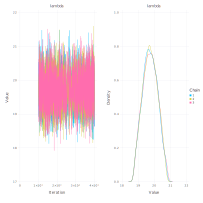

In [14]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

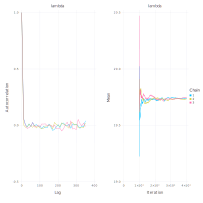

In [15]:
p0 = Mamba.plot(sim0, [:autocor, :mean], legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

### 変化はあるか？
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda_t = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(0,N)
\end{align}
とする。

In [16]:
model1 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, tau, N) -> 
            (out = fill(lambda1, N);
            i = Int64(tau.value) + 1; # Juliaは1-indexingのため
            out[i:end, :] .= lambda2;
            out),
        false),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    
    tau = Stochastic(N -> DiscreteUniform(0, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


In [17]:
inits1 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :tau => 1,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)

In [18]:
scheme1 = [AMWG([:lambda1, :lambda2], 1.0), DGS(:tau)]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau])), Const(##238#241(Box(Symbol[:tau])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                       

In [19]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data0, inits1, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 2:   0% [1:30:41 of 1:30:43 remaining]
      From worker 3:	Chain 1:   0% [1:33:19 of 1:33:20 remaining]
      From worker 4:	Chain 3:   0% [1:36:43 of 1:36:45 remaining]
      From worker 3:	Chain 1:  10% [0:01:50 of 0:02:02 remaining]
      From worker 2:	Chain 2:  10% [0:01:51 of 0:02:03 remaining]
      From worker 4:	Chain 3:  10% [0:01:52 of 0:02:05 remaining]
      From worker 3:	Chain 1:  20% [0:01:32 of 0:01:55 remaining]
      From worker 2:	Chain 2:  20% [0:01:34 of 0:01:58 remaining]
      From worker 4:	Chain 3:  20% [0:01:35 of 0:01:58 remaining]
      From worker 3:	Chain 1:  30% [0:01:20 of 0:01:55 remaining]
      From worker 4:	Chain 3:  30% [0:01:21 of 0:01:56 remaining]
      From worker 2:	Chain 2:  30% [0:01:22 of 0:01:57 remaining]
      From worker 3:	Chain 1:  40% [0:01:13 of 0:02:02 remaining]
      From worker 4:	Chain 3:  40% [0:01:14 of 0:02:04 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[45.0 21.702 16.6991; 45.0 23.9977 18.4577; … ; 45.0 24.441 17.5544; 45.0 22.8497 18.405]

[45.0 24.9529 17.2422; 43.0 21.2132 16.8855; … ; 45.0 23.1503 17.6967; 45.0 23.1503 17.6967]

[43.0 22.2825 17.4803; 43.0 21.7565 18.0704; … ; 44.0 21.8661 18.7898; 45.0 21.9384 18.1761]

In [20]:
describe(sim1)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
           Mean       SD      Naive SE       MCSE        ESS   
    tau 44.362778 2.3382329 0.0246471389 0.107189616  475.85004
lambda2 22.687355 1.0479549 0.0110464144 0.039013224  721.54180
lambda1 17.771601 0.6530360 0.0068836036 0.012720151 2635.66181

Quantiles:
           2.5%     25.0%     50.0%     75.0%     97.5%  
    tau 42.000000 44.000000 44.000000 45.000000 45.000000
lambda2 20.964238 22.109696 22.704179 23.309565 24.483794
lambda1 16.549777 17.332510 17.756916 18.192561 19.072208



In [21]:
gelmandiag(sim1, mpsrf = true, transform = true)

              PSRF 97.5%
         tau 1.136 1.164
     lambda2 1.071 1.079
     lambda1 1.002 1.005
Multivariate 1.009   NaN



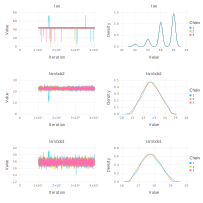

In [22]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:3], nrow = 3, ncol = 2)

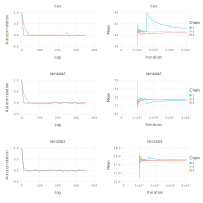

In [23]:
p1 = Mamba.plot(sim1, [:autocor, :mean], legend = true)
Mamba.draw(p1[:, 1:3], nrow = 3, ncol = 2)